<a href="https://colab.research.google.com/github/Hemant01912/Hemant01912.github.io/blob/main/MangoLeafWorkingCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import requests

In [ ]:
dataset_url = 'https://www.kaggle.com/api/v1/datasets/download/aryashah2k/mango-leaf-disease-dataset'
r = requests.get(dataset_url)
with open('dataset.zip', 'wb') as f:
    f.write(r.content)
!unzip dataset.zip -d dataset

Archive:  dataset.zip
  inflating: dataset/Anthracnose/20211008_124249 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124250 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124252 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124253 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124256 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124301 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124302 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124305 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124306 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124310 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124312 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124334 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124336 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124341 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124345 (Custom).jpg  
  inflating: datas

In [ ]:
dataset_dir = "dataset"
batch_size = 32
img_height = 150
img_width = 150

In [ ]:
def display_samples(dataset_dir, num_samples=4):
    classes = os.listdir(dataset_dir)
    plt.figure(figsize=(15, len(classes) * 3))

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        images = os.listdir(class_dir)[:num_samples]
        for i, image_name in enumerate(images):
            image_path = os.path.join(class_dir, image_name)
            img = load_img(image_path, target_size=(img_height, img_width))
            plt.subplot(len(classes), num_samples, idx * num_samples + i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

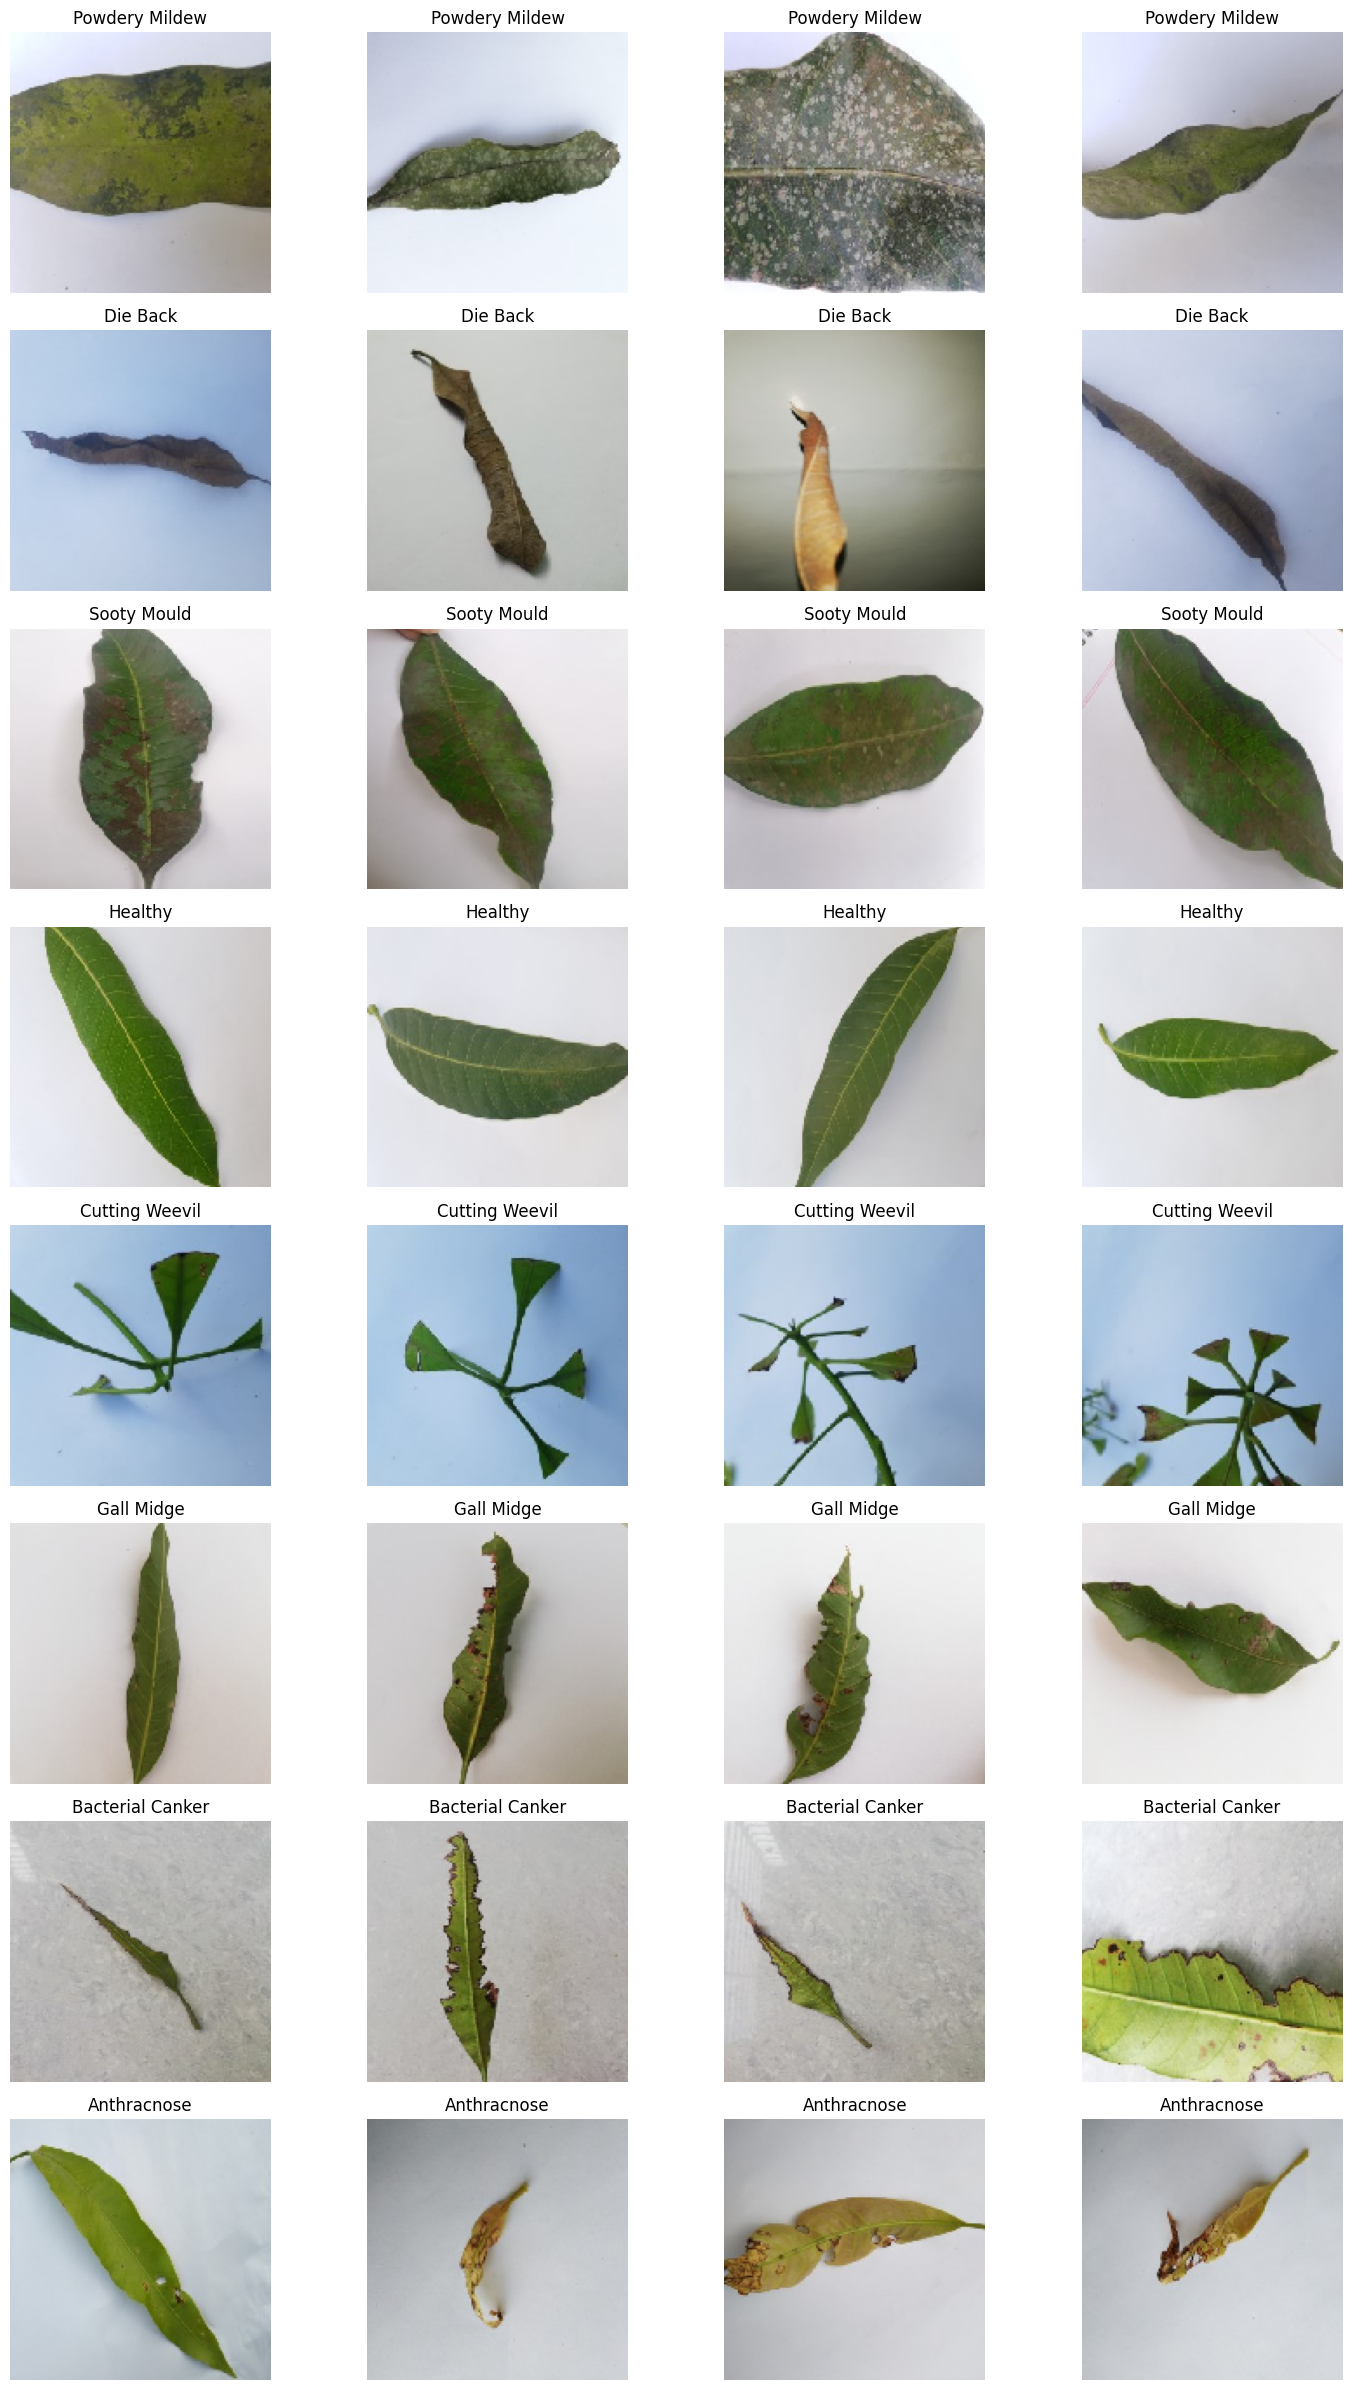

In [ ]:
display_samples(dataset_dir, num_samples=4)

In [ ]:
rescaled_images = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
training_data = rescaled_images.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 3200 images belonging to 8 classes.


In [ ]:
testing_data = rescaled_images.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 800 images belonging to 8 classes.


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(training_data.num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    training_data,
    validation_data=testing_data,
    epochs=1,
    steps_per_epoch=training_data.samples // batch_size,
    validation_steps=testing_data.samples // batch_size
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.2243 - loss: 2.1500 - val_accuracy: 0.2837 - val_loss: 1.6006


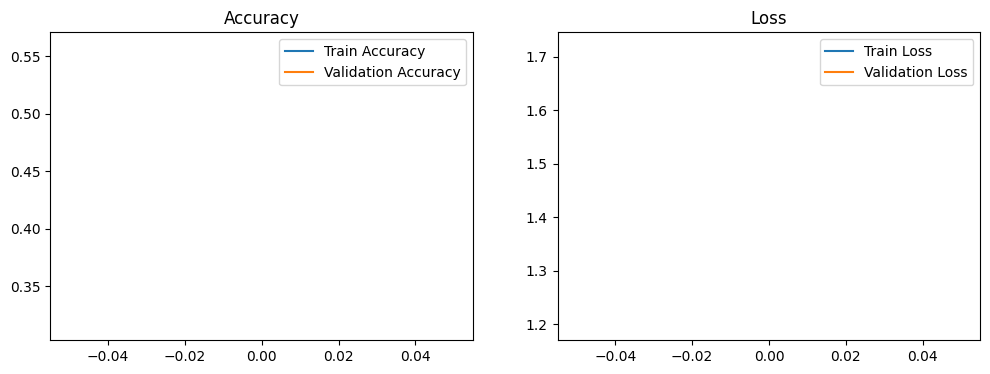

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
model.save("mango_leaf_disease_model_v2.h5")

In [ ]:
model = tf.keras.models.load_model("mango_leaf_disease_model_v2.h5")

In [ ]:
def test_custom_image(test_image_path):
  test_img = load_img(test_image_path, target_size=(img_height, img_width))
  test_img_array = img_to_array(test_img) / 255.0
  test_img_array = np.expand_dims(test_img_array, axis=0)

  predictions = model.predict(test_img_array)
  predicted_class = np.argmax(predictions[0])

  class_indices = training_data.class_indices
  class_labels = {v: k for k, v in class_indices.items()}

  predicted_label = class_labels[predicted_class]

  plt.imshow(test_img)
  plt.title(f"Predicted: {predicted_label}")
  plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


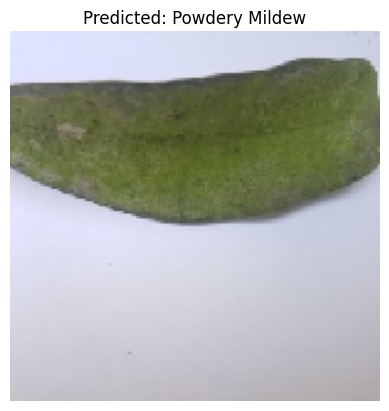

In [ ]:
test_custom_image("/content/dataset/Powdery Mildew/20211109_121158 (Custom).jpg")
